# Data Science Project 1 -  Improve the mass accuracy of spectra measured by Orbitrap mass spectrometers (orbitrap)

**Client:** Atmospheric Physical Chemistry group, INAR, University of Helsinki

**Description:** Motivation: When using a mass spectrometer, the measured mass usually shifts from its true mass. Hence, a mass calibration is an important procedure before allocating chemical formulae to the measured masses. A good mass calibration may greatly reduce the efforts of further analysis and increase the reliability of the results. Goals: Improve the mass calibration procedure for Orbitrap raw data, and perhaps for data measured by other mass spectrometers, e.g, TOF-MS Main tasks: 1) Test several fitting function for mass correction, and recommend one or a few that works best. 2) Test the performance of different parameters for mass correction, e.g., number of mass of the species for calibration.

**Data and tools:** Data: raw spectrum data measured by Orbitrap mass spectrometer. Tools: a) Orbitool, provided by the client. Orbitool will be used for reading the raw data and remove the noise, i.e., prepare the data for this analysis; b) Any programming language, which will be used to investigate this mass calibration problem.

## Environment

The environment should have the dependencies to run Orbitool and this notebook.

```bash
# Import environment
conda env create -f environment.yml

# Import kernel to jupyter
ipython kernel install --user --name=orbitool

# Export the environment to file
conda env export --no-builds > environment.yml
```

## Notebook practices

* Clean outputs before commiting!

## Dependencies

In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.signal import find_peaks
from scipy.optimize import leastsq
from pyteomics import mass
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import random
import itertools

## Data exploration

### Read the spectrum data

* Put the directory of spectrum CSV files to ```spectrum_data_directory``` variable.
    * If the begining of the CSV files contains some time information, then set ```contains_time_data``` variable to ```True```.
* Put the path of the peak list file to ```peak_list_file``` variable.
* If you just want to test the code, then you can speed up the code by setting the size of spectrum sample to ```random_sample_size``` variable.

In [2]:
spectraRoot = ""
peaklistRoot = ""
spectrum_data_directory = spectraRoot + "data/First Large Deviation file-20210415T191813Z-001/First Large Deviation file/2 mins"
contains_time_data = False #Spectrum files contains time data in forst 3 rows?
peak_list_file = peaklistRoot + "peak list/peaklist_1e5_background.csv"
random_sample_size = None #Take sample spectrums to speed up things. If 'None' then uses all the spectrums

spectrum_data_files = []
time_data = []
spectrums = []

# Get data files
for file in [f for f in listdir(spectrum_data_directory) if isfile(join(spectrum_data_directory, f))]:
    path_to_file = join(spectrum_data_directory, file)
    #print(path_to_file)
    if file.endswith(".csv"):
        spectrum_data_files.append(path_to_file)

# Take sample spectrums to speed up things
if random_sample_size:
    spectrum_data_files = random.sample(spectrum_data_files, min(random_sample_size, len(spectrum_data_files)))

# Read the spectrum files
for file in spectrum_data_files:
    if contains_time_data:
        time_data.append(pd.read_csv(file)[:2])
        spectrums.append(pd.read_csv(file, skiprows = 3).sort_values(by=['mz']))
    else:
        spectrums.append(pd.read_csv(file))

peak_list = dict(pd.read_csv(peak_list_file).values)

# Lookup
spectrums[0].head(5)

,mz,intensity
0,50.150331,0.000000
1,50.150352,0.110786
2,50.150373,1.737762
3,50.150394,5.654681
4,50.150415,10.029099


### Plot  the spectrums

* Plot all the spectrums with actual ions (from peak list file).

0.11.1


<IPython.core.display.Javascript object>


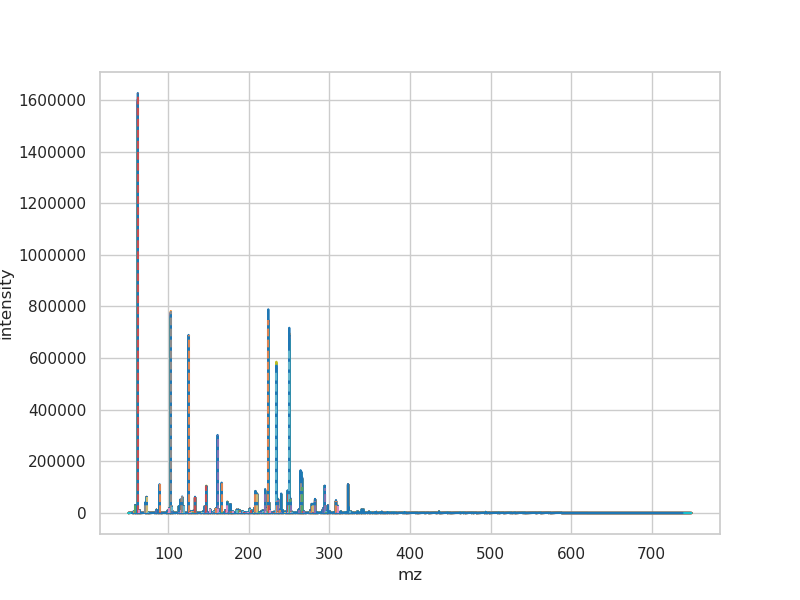

In [257]:
%matplotlib notebook
# seaborn version should be at least 0.11!
print(sns.__version__)

# Concat files to same data frame with 'spectrum' separator column
tmp = pd.concat(spectrums, keys=range(len(spectrum_data_files)), names=["spectrum"])

# Plot the spectrums
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(data=tmp, ax=ax, x="mz", y="intensity", hue="spectrum", palette="tab10")
ax.legend([],[], frameon=False)
ax.ticklabel_format(useOffset=False)

# Plot the actual masses. Line height is taken from max intensity with +-eps interval.
eps = 0.0001
for formula, mz in peak_list.items():
    max_intensity = max([x for x in tmp.loc[(tmp["mz"] > mz - eps) & (tmp["mz"] < mz + eps)].intensity.values] + [0.0])
    plt.plot((mz,mz), (0.0,max_intensity), linestyle="--")

## Detect peaks

* Detect peaks
* Calculate/get some information about the peaks

In [3]:
def find_peak_indices(data):
    '''
    Logic is same as in Koli's implementation. Tested that produces same results with spectrums in
    "data/CI-orbi_20201117165601 folder (first smal deviation file)/1 min" folder.
    '''
    peak_start_indices = [0] #Initialize with first start index
    peak_end_indices = []
    for i, row in data.iterrows():
        if i == 0:
            continue;
        if data.iloc[i]["intensity"] == 0.0 and data.iloc[i - 1]["intensity"] == 0.0:
            peak_start_indices.append(i)
            peak_end_indices.append(i - 1)
    peak_end_indices.append(len(data) - 1) #Finalize with last end index
    return np.column_stack((peak_start_indices, peak_end_indices))

peak_informations = []
for spectrum in spectrums:
    peak_information = []
    for start, end in find_peak_indices(spectrum):
        data = spectrum.iloc[start:(end+1)]
        max_intensity = data["intensity"].max()
        width = data["mz"].max() - data["mz"].min()
        average_mz = np.average(data["mz"], weights=data["intensity"])
        peak_information.append({
            "start": start,
            "end": end,
            "max_intensity": max_intensity,
            "average_mz": average_mz,
            "width": width
        })
    peak_informations.append(pd.DataFrame(peak_information))
    
peak_informations[0].head(5)

,start,end,max_intensity,average_mz,width
0,0,9,12.283237,50.150437,0.000189
1,10,19,14.338086,51.260119,0.000196
2,20,32,11.760868,51.410406,0.000262
3,33,41,14.901824,51.754738,0.000177
4,42,53,14.245267,51.919683,0.000244


### Handle 'double peaks'

* Converts 'double peaks' to separate peaks.

In [ ]:
# TODO

## Fit Gaussian curve to peaks

* Fit Gaussian curve to peaks and get fitted means.
* Set the wanted resolution to ```default_resolution``` variable.

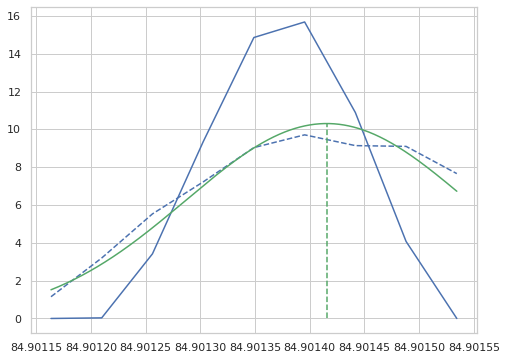

In [11]:
default_resolution = 280000

# x: data; a: height; x0: position; c: sigma or width
gauss  = lambda x, a, mu, sigma: a*np.exp(-(x-mu)**2/(2*sigma**2))

def fit_gaussian(peak, resolution=default_resolution, show=False, use_rolling = None):
    '''
    returns: a: 'height'; mu: 'position'; sigma: 'width'
    '''
    intensity = peak["intensity"] if not use_rolling else peak["intensity"].rolling(use_rolling, center=True, min_periods=1).mean()
    mu = np.average(peak["mz"], weights=intensity)
    sigma = mu/(resolution*2*np.sqrt(2*np.log(2)))
    errfunc  = lambda p, x, y: (y - gauss(x, p[0], p[1], sigma))
    init  = [intensity.max(), mu]
    out = leastsq(errfunc, init, args=(peak["mz"], intensity), maxfev = 200)
    c = out[0]
    if show:
        sns.set_theme(style="whitegrid")
        x = np.linspace(peak["mz"].min(), peak["mz"].max(), 1000)
        fig, ax = plt.subplots(figsize=(8,6))
        ax.ticklabel_format(useOffset=False)
        plt.plot(peak["mz"], peak["intensity"], "b")
        if use_rolling:
            plt.plot(peak["mz"], intensity, "b", linestyle="--")
        plt.plot(x, gauss(x, c[0], c[1], sigma), "g")
        plt.plot((c[1],c[1]), (0.0,c[0]), "g", linestyle="--")
    return c[0], c[1], sigma

# Test Fitting
n_spectrum = 0
n_peak = 163

spectrum = spectrums[n_spectrum]
peak_information = peak_informations[n_spectrum]
peak = peak_information.iloc[n_peak]
data = spectrum.iloc[int(peak["start"]):int(peak["end"] + 1)]
a, mu, sigma = fit_gaussian(data, show=True, use_rolling = 6)

In [5]:
# Add 'observed_mz' column
for spectrum, peak_information in zip(spectrums, peak_informations):
    fitted_means = []
    for i, peak in peak_information.iterrows():
        data = spectrum.iloc[int(peak["start"]):int(peak["end"] + 1)]
        a, mu, sigma = fit_gaussian(data)
        fitted_means.append(mu)
    peak_information["observed_mz"] = fitted_means
    
peak_informations[0].head(5)

/home/jaakko/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 200.
  warnings.warn(errors[info][0], RuntimeWarning)


,start,end,max_intensity,average_mz,width,observed_mz
0,0,9,12.283237,50.150437,0.000189,50.150441
1,10,19,14.338086,51.260119,0.000196,51.260116
2,20,32,11.760868,51.410406,0.000262,51.410400
3,33,41,14.901824,51.754738,0.000177,51.754738
4,42,53,14.245267,51.919683,0.000244,51.919680


## Classify ions

* Associate every ion from the ```peak_list``` to closest detected peak if there is detected peaks closer than ```theta```.

In [6]:
def identify_peaks(peak_information, peak_list, theta = 0.0005):
    peak_information["formula"] = None # For strings
    peak_information["formula_mz"] = np.nan # For floats
    for key in peak_list.keys():
        formula = key
        true_mz = peak_list[key]
        closest = peak_information[np.abs(peak_information["observed_mz"] - true_mz) < theta]
        if len(closest) > 0:
            closest = closest.iloc[(closest['observed_mz'] - true_mz).abs().argsort()[:1]]
            #print("True: {}; Observed: {}; Index: {}".format(true_mz, closest["observed"].values[0], closest.index.values[0]))
            peak_information.at[closest.index.values[0], "formula"] = formula
            peak_information.at[closest.index.values[0], "formula_mz"] = true_mz
    peak_information["error"] =  peak_information["formula_mz"] - peak_information["observed_mz"]

# Identify peaks
for peak_information in peak_informations:
    identify_peaks(peak_information, peak_list)

# Lookup
peak_informations[0].loc[peak_informations[0]["formula"].notnull()]

,start,end,max_intensity,average_mz,width,observed_mz,formula,formula_mz,error
27,315,339,6.078161e+03,57.034489,0.000613,57.034488,C3H5O-,57.034588,0.000100
37,447,464,2.819150e+04,59.013783,0.000457,59.013786,C2H3O2-,59.013853,0.000066
58,889,926,1.508852e+06,61.988334,0.001071,61.988348,O3N-,61.988366,0.000019
89,1419,1436,5.175148e+03,62.985388,0.000504,62.985390,O3N[15]-,62.985401,0.000012
90,1437,1450,1.550411e+03,62.992570,0.000385,62.992571,O2O[17]N-,62.992584,0.000013
...,...,...,...,...,...,...,...,...,...
1591,20190,20199,6.295666e+01,325.088609,0.003127,325.088591,C10H17O10N2-,325.088868,0.000277
1597,20273,20285,5.750743e+03,326.072757,0.004189,326.072763,C10H16O11N-,326.072884,0.000121
1638,20757,20770,7.861306e+02,336.093568,0.004749,336.093575,C12H18O10N-,336.093619,0.000044
1649,20880,20891,3.327374e+02,338.072793,0.004054,338.072790,C11H16O11N-,338.072884,0.000094


## Uncertainty of mass

* Analyse uncertainty of mass.

The calculateMassUncertainty function takes a dataframe containing a processed spectrum with the following columns: formula, mz, observerd.
It returns a dictionary with the uncertainty for each element calculated as the average of all the uncertainties for wich the element was present.
By default it will take perform a weighted averged based on the number of elements in the compounds/ions.
If weighted is set to False, it will only average the uncertainty based solely on the presence of the element.


In [16]:
%matplotlib notebook

def calculateMassUncertainty(peak_information, weighted=True, dfOutput=True, show=False):
    elements = {}
    for index, row in peak_information.iterrows():
        ion = row["formula"]
        if not ion:
            continue;
        ion = ion if ion[-1] != '-' else ion[:-1]
        tmp = mass.Composition(formula=ion)
        v = row["error"]
        total = sum(tmp.values())
        for e in tmp.keys():
            f = 1
            if weighted:
                f = tmp[e] / total
            if e not in elements:
                elements[e] = [v*f]
            else:
                elements[e].append(v*f)
    for e in elements.keys():
        elements[e] = sum(elements[e]) / len(elements[e])
    if show:
        keys = elements.keys()
        values = elements.values()
        plt.figure(1)
        plt.bar(keys, values)
    if dfOutput:
        df = pd.DataFrame(elements.items(), columns=['Element', 'Uncertainty'])
        return df
    else:
        return elements
    
tmp = pd.concat(peak_informations, keys=range(len(spectrum_data_files)), names=["spectrum"])
calculateMassUncertainty(tmp, True, True,True)

<IPython.core.display.Javascript object>

,Element,Uncertainty
0,C,0.000034
1,H,0.000049
2,O,0.000031
3,N,0.000005
4,N[15],0.000007
5,O[17],0.000004
6,O[18],0.000001
7,C[13],0.000008
8,F,0.000005
9,H[2],0.000017


## Fit linear/polynomial regression model

* Fits linear/polynomial model to ```error``` column.
* ```MultiPolyModel``` is collection of polynomial models with different degrees (can also be used only with single degree). Prediction result is averaged result from the models (can be weighted).

### Useful links

* https://realpython.com/linear-regression-in-python/
* https://towardsdatascience.com/polynomial-regression-which-python-package-to-use-78a09b0ac87b
* https://stackoverflow.com/questions/34373606/scikit-learn-coefficients-polynomialfeatures

Degrees: [4]; Weights: [1]
Degrees: [1 2 3 4 5 6 7 8]; Weights: [1.         0.70710678 0.57735027 0.5        0.4472136  0.40824829
 0.37796447 0.35355339]


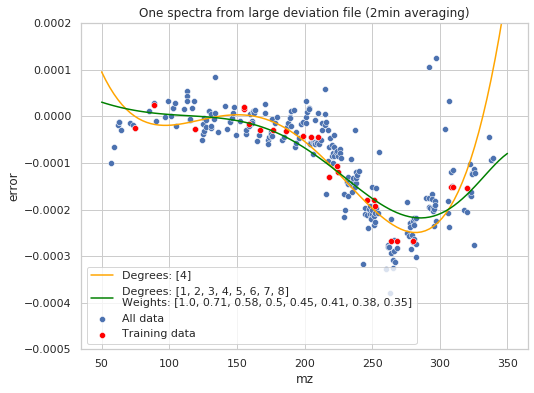

In [54]:
#%matplotlib inline

class MultiPolyModel:
    '''
    Fits multiple polynomial models with different degrees. Prediction value is average value of 
    predicted values from different models (weigths can be used).
    
    If 'max_degree = min_degree' then this is just simple single polynomial model with degree of 
    'max_degree' (or 'max_degree').
    '''
    degrees = None
    weights = None
    models = None
    
    debug = False
    
    def __init__(self, degrees, weights = None, debug = False):
        '''
        Initializes model.
        
        Arguments:
            min_degree: Minium degree of model (first model).
            max_degree: Maximum degree of model (last model).
            weight: None, Integer, or List
                None: Weights are degrees in inversed order (exmpl. degrees: [1,2,3] then weights: [3,2,1]).
                Integer: All models have same weight (value doesn't matter).
                List: Weights (size should be amout of models i.e. 'max_degree-min_degree+1').
        '''
        self.models = []
        self.degrees = np.array(degrees)
        self.debug = debug
        
        if weights and type(weights) == int:
            self.weights = np.repeat(weights, len(self.degrees))
        elif weights and type(weights) == list:
            self.weights = np.array(weights)
        else:
            self.weights = 1 / self.degrees
            
        if self.debug:
            print("Degrees: {}; Weights: {}".format(self.degrees, self.weights))
            
    def fit_poly_reg_model(self, x, y, degree, show = False, ax = None, color="r"):
        poly_features = PolynomialFeatures(degree)
        model = make_pipeline(poly_features, LinearRegression()).fit(x.reshape(-1, 1), y)
        if show:
            print("Coefficients: {}".format(model.steps[1][1].coef_[1:]), "Independent: {}".format(model.steps[1][1].intercept_))
            preds = model.predict(x.reshape(-1, 1))
            sns.set_theme(style="whitegrid")
            if not ax:
                fig, ax = plt.subplots(figsize=(8,6))
            sns.scatterplot(x=x, y=y, ax=ax, color=color)
            plt.plot(x, preds, linestyle="-", color=color)
        return model
    
    def fit(self, x, y, show=False, color="r", ax = None):
        for degree in self.degrees:
            self.models.append(self.fit_poly_reg_model(x, y, degree = degree))
        if show:
            x_plot = np.linspace(min(x), max(x), 100)
            preds = self.predict(x_plot)
            sns.set_theme(style="whitegrid")
            if not ax:
                fig, ax = plt.subplots(figsize=(8,6))
            sns.scatterplot(x=x, y=y, ax=ax, color=color)
            plt.plot(x_plot, preds, linestyle="-", color=color)
    
    def predict(self, x):
        results = []
        for model in self.models:
            results.append(model.predict(x.reshape(-1, 1)))
        return np.average(np.array(results), axis=0, weights = self.weights)    

peak_information = peak_informations[0]
peak_information = peak_information[peak_information["error"].notnull()]

# TODO: better peak selection
#train = peak_information[peak_information["max_intensity"] > 10000]
train, test = selectPeaksFromPartitions(peak_information, 3, 8, select=selectPeaksMeanError)

degrees1 = [4]
degrees2 = [1,2,3,4,5,6,7,8]
weights2 = [1/np.sqrt(d) for d in degrees2]

model = MultiPolyModel(degrees1, weights = 1, debug = True)
model.fit(train["observed_mz"].values, train["error"].values*-1)

model1 = MultiPolyModel(degrees2, weights = weights2, debug = True)
model1.fit(train["observed_mz"].values, train["error"].values*-1)

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x=peak_information["observed_mz"].values, y=peak_information["error"].values*-1, ax=ax)
sns.scatterplot(x=train["observed_mz"].values, y=train["error"].values*-1, ax=ax, color="red")
x = np.linspace(50, 350, 100)
y = model.predict(x)
y1 = model1.predict(x)
sns.lineplot(x=x, y=y, color="orange", ax=ax)
sns.lineplot(x=x, y=y1, color="green", ax=ax)
plt.legend(["Degrees: {}".format(degrees1), "Degrees: {}\nWeights: {}".format(degrees2, [round(w, 2) for w in weights2]), "All data", "Training data"])

plt.title("One spectra from large deviation file (2min averaging)")
ax.set_ylabel("error")
ax.set_xlabel("mz")
_ = ax.set_ylim([-0.0005, 0.0002])

## Peak selection methods

### Method 1: Select best n peaks

This first idea is to select a set amount n of the best peaks to lead the calibration process. It is possible to set a treshold to specifiy the minimal value of error accepted.  
The threshold criteria is secondary to the number of peaks, meaning that if the threshold isn't met and the number of peaks selected is under n, it will put those below the threshold to reach n. To change this set the forceThreshold parameter to True.  
To disable thr threshold set it to 0 (default value).  
The treshold is treated as absolute value, so negative values don't matter.  
This method provides the remaining peaks as a test set, and the size can be specified with the test_n parameter. If left at 0 it will return all the discarded data for testing.  
The randomTestSamples parameter allows to sample randomly from the remaining data, otherwise they're provided ordered by least uncerteinty value.

In [8]:
def selectBestPeaks(data, n=10, threshold=0, forceThreshold=False, test_n=0, randomTestSamples=True, debug=False):
    if n <=0:
        return None
    result = data.copy()
    result["absolute_error"] =  abs(data["error"])
    result = result.sort_values(by=['absolute_error'], ascending=True) #specified ascending parameter for flexibility
    diff = result
    test_n = abs(test_n)
    
    if debug:    
        print(result)
    
    if threshold:
        threshold = abs(threshold)
        filtered = result[result['absolute_error']<=threshold]
    
    if len(result) > n:
        if threshold:
            if len(filtered) > n:
                result = filtered[0:n]
            else:
                if forceThreshold:
                    result = filtered
                else:
                    result = result[0:n]
        else:
            result = result[0:n]
    else:
        if forceThreshold and threshold:
            result = filtered
        else:
            x = max(len(result), n)
            result = result[0:x]
            
    diff = pd.concat([result,diff]).drop_duplicates(keep=False)
    if test_n != 0:
        test_n = min(test_n, len(diff))
        if randomTestSamples:
            diff = diff.sample(test_n)
        else:
            diff = diff[0:test_n]
    return result, diff

a, b = selectBestPeaks(peak_informations[0], 5, 1.397722e-06, False, 10, True)

### Method 2: Select best peaks from partitions by criteria

In [9]:
# Choose n peaks with the smallest error
def selectPeaksMinimumError(peak_information, n):
    errors = abs(peak_information["error"])
    ind = np.argpartition(errors, n)
    return peak_information.iloc[ind[:n],:], peak_information.iloc[ind[n:],:]

# Choose n peaks with error closest to the mean error
def selectPeaksMeanError(peak_information, n):
    errors = abs(peak_information["error"])
    ind = np.argpartition(abs(errors-np.mean(errors)), n)
    return peak_information.iloc[ind[:n],:], peak_information.iloc[ind[n:],:]

# Choose n peaks with error closest to the median error
def selectPeaksMedianError(peak_information, n):
    errors = abs(peak_information["error"])
    ind = np.argpartition(abs(errors-np.median(errors)), n)
    return peak_information.iloc[ind[:n],:], peak_information.iloc[ind[n:],:]

# Splits the peaks into k partitions and selects n peaks from each partition
# so it results in n*k peaks for training and the rest of the peaks for testing
def selectPeaksFromPartitions(peak_information, n, k, select=selectPeaksMedianError):
    n_peaks = len(peak_information)
    partition_size = int((n_peaks - (n_peaks % k)) / k)
    test = pd.DataFrame(columns=peak_information.columns)
    train = pd.DataFrame(columns=peak_information.columns)
    for i in range(k):
        if i < k-1:
            partition = peak_information.iloc[i*partition_size:(i+1)*partition_size,:]
        else:
            partition = peak_information.iloc[i*partition_size:,:]
        tr, ts = select(partition, n)
        test = test.append(ts)
        train = train.append(tr)
    return train, test

### Test first peak selection method

In [81]:
random.seed(111)

train_information = []
# Single degree models
for n_train in [10, 20, 30, 40, 50]:
    for degrees in [[i] for i in range(1, 7)] + [list(range(1,i)) for i in range(3, 8)]:
        for weight in [1, [1/np.sqrt(d) for d in degrees]]:
            if len(degrees) == 1 and type(weight) != int:
                continue
            mses = []
            for peak_information in peak_informations:
                peak_information = peak_information[peak_information["error"].notnull()]
                train, test = selectBestPeaks(peak_information, n=n_train, randomTestSamples=False)
                model = MultiPolyModel(degrees, weights = weight)
                model.fit(train["observed_mz"].values, train["error"].values*-1)
                preds = model.predict(test["observed_mz"].values)
                mse = mean_squared_error(test["error"].values*-1, preds)
                mses.append(mse)
            train_information.append({
                "degrees": degrees,
                "weights": [round(w, 3) for w in model.weights],
                "n_train": n_train,
                "mean_mse": np.mean(mses),
                "std_mse": np.std(mses),
                "min_mse": np.min(mses),
                "max_mse": np.max(mses)
            })
        
training_result1 = pd.DataFrame(train_information).sort_values(by=['mean_mse', "std_mse", "max_mse"], ascending=True)
training_result1.head(20)

,degrees,weights,n_train,mean_mse,std_mse,min_mse,max_mse
16,[1],[1],20,2.797646e-08,6.625628e-09,1.789916e-08,4.301349e-08
0,[1],[1],10,2.799554e-08,8.289219e-09,1.586816e-08,4.894224e-08
23,"[1, 2]","[1.0, 0.707]",20,2.827385e-08,6.913418e-09,1.736883e-08,4.302521e-08
22,"[1, 2]","[1, 1]",20,2.834296e-08,7.004103e-09,1.715248e-08,4.302791e-08
49,[2],[1],40,2.843307e-08,7.614764e-09,1.863411e-08,4.439406e-08
25,"[1, 2, 3]","[1.0, 0.707, 0.577]",20,2.845968e-08,7.139758e-09,1.670546e-08,4.276513e-08
24,"[1, 2, 3]","[1, 1, 1]",20,2.859299e-08,7.422947e-09,1.636243e-08,4.343457e-08
32,[1],[1],30,2.864912e-08,6.662632e-09,1.773235e-08,4.463689e-08
17,[2],[1],20,2.879716e-08,7.736594e-09,1.594090e-08,4.349148e-08
54,"[1, 2]","[1, 1]",40,2.901370e-08,6.666855e-09,1.872054e-08,4.360778e-08


### Test second peak selection method

In [78]:
train_information = []
for n_partitions in [5,6,7,8]:
    for peak_per_partition in [2,3,4,5]:
        for degrees in [[i] for i in range(1, 7)] + [list(range(1,i)) for i in range(5, 12)]:
            for weight in [1, [1/np.sqrt(d) for d in degrees]]:
                if len(degrees) == 1 and type(weight) != int:
                    continue
                for select in [selectPeaksMinimumError, selectPeaksMeanError, selectPeaksMedianError]:
                    mses = []
                    for peak_information in peak_informations:
                        peak_information = peak_information[peak_information["error"].notnull()]
                        train, test = selectPeaksFromPartitions(peak_information, peak_per_partition, n_partitions, select=select)
                        model = MultiPolyModel(degrees, weights = weight)
                        model.fit(train["observed_mz"].values, train["error"].values*-1)
                        preds = model.predict(test["observed_mz"].values)
                        mse = mean_squared_error(test["error"].values*-1, preds)
                        mses.append(mse)
                    train_information.append({
                        "degrees": degrees,
                        "weights": [round(w, 2) for w in model.weights],
                        "partitions": n_partitions,
                        "ppp": peak_per_partition,
                        "select": select.__name__,
                        "mean_mse": np.mean(mses),
                        "std_mse": np.std(mses),
                        "min_mse": np.min(mses),
                        "max_mse": np.max(mses)
                    })
        
training_result = pd.DataFrame(train_information).sort_values(by=["mean_mse", "std_mse", "max_mse"], ascending=True)
training_result.head(20)
training_result.to_csv("training_result.csv", sep="\t")

In [79]:
test = training_result.head(10).style.format({"mean_mse": "{:.2E}", "std_mse": "{:.2E}", "max_mse": "{:.2E}", "min_mse": "{:.2E}"})
test

,degrees,weights,partitions,ppp,select,mean_mse,std_mse,min_mse,max_mse
650,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 1, 1, 1, 1, 1, 1, 1, 1]",7,4,selectPeaksMedianError,3.41E-09,4.60E-10,2.63E-09,4.23E-09
950,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 1, 1, 1, 1, 1, 1, 1, 1]",8,5,selectPeaksMedianError,3.42E-09,6.07E-10,2.38E-09,5.39E-09
710,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 1, 1, 1, 1, 1, 1, 1, 1]",7,5,selectPeaksMedianError,3.42E-09,4.58E-10,2.68E-09,4.38E-09
677,[6],[1],7,5,selectPeaksMedianError,3.44E-09,1.06E-09,2.33E-09,7.82E-09
704,"[1, 2, 3, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 1, 1, 1]",7,5,selectPeaksMedianError,3.45E-09,4.76E-10,2.71E-09,4.46E-09
944,"[1, 2, 3, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 1, 1, 1]",8,5,selectPeaksMedianError,3.46E-09,6.22E-10,2.37E-09,5.53E-09
656,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",7,4,selectPeaksMedianError,3.47E-09,5.91E-10,2.58E-09,5.18E-09
878,"[1, 2, 3, 4, 5, 6, 7]","[1, 1, 1, 1, 1, 1, 1]",8,4,selectPeaksMedianError,3.50E-09,6.68E-10,2.43E-09,5.87E-09
956,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",8,5,selectPeaksMedianError,3.51E-09,5.24E-10,2.46E-09,4.80E-09
938,"[1, 2, 3, 4, 5, 6, 7]","[1, 1, 1, 1, 1, 1, 1]",8,5,selectPeaksMedianError,3.51E-09,5.62E-10,2.44E-09,4.84E-09
